In [0]:
!pip install tensorflow==2.0.0-alpha0
!pip install -q tensorflow-hub
!pip install contractions
!pip install beautifulsoup4

In [0]:
import tensorflow as tf
import tensorflow_hub as tf_hub
import pandas as pd
import numpy as np

In [3]:
tf.test.is_gpu_available()

False

In [4]:
url = 'https://github.com/dipanjanS/data_science_for_all/blob/master/tds_deep_transfer_learning_nlp_classification/movie_reviews.csv.bz2?raw=true'
dataset = pd.read_csv(url, compression='bz2')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [6]:
dataset['sentiment'] = dataset.sentiment.map({"positive": 1, "negative": 0})
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:30000]
train_sentiments = sentiments[:30000]

val_reviews = reviews[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000,), (5000,), (15000,))

In [0]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [0]:
train_reviews = pre_process_corpus(train_reviews)
val_reviews = pre_process_corpus(val_reviews)
test_reviews = pre_process_corpus(test_reviews)

In [0]:
X_train = np.asarray(train_reviews)
X_valid = np.asarray(val_reviews)

y_train = np.array(train_sentiments)
y_valid = np.array(val_sentiments)

In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
download_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = tf_hub.Module(download_url, trainable=True)

In [0]:
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [0]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(UniversalEmbedding, output_shape=(512, ))(input_text)
dense = Dense(128, activation='relu')(embedding)
pred = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=[input_text], outputs=pred)

optimizer = tf.keras.optimizers.Adagrad(lr=0.005)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 65,793
Trainable params: 65,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [38]:
with tf.compat.v1.Session() as session:
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=12, batch_size=256, callbacks=[es_cb])

Train on 30000 samples, validate on 5000 samples
Epoch 1/12
30000/30000 [==============================] - 58s 2ms/sample - loss: 0.6905 - accuracy: 0.5556 - val_loss: 0.6865 - val_accuracy: 0.6384
Epoch 2/12
30000/30000 [==============================] - 55s 2ms/sample - loss: 0.6829 - accuracy: 0.6764 - val_loss: 0.6792 - val_accuracy: 0.7162
Epoch 3/12
30000/30000 [==============================] - 56s 2ms/sample - loss: 0.6755 - accuracy: 0.7353 - val_loss: 0.6718 - val_accuracy: 0.7538
Epoch 4/12
30000/30000 [==============================] - 56s 2ms/sample - loss: 0.6679 - accuracy: 0.7619 - val_loss: 0.6643 - val_accuracy: 0.7708
Epoch 5/12
30000/30000 [==============================] - 56s 2ms/sample - loss: 0.6601 - accuracy: 0.7748 - val_loss: 0.6564 - val_accuracy: 0.7774
Epoch 6/12
30000/30000 [==============================] - 57s 2ms/sample - loss: 0.6517 - accuracy: 0.7817 - val_loss: 0.6480 - val_accuracy: 0.7802
Epoch 7/12
30000/30000 [==============================] -

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

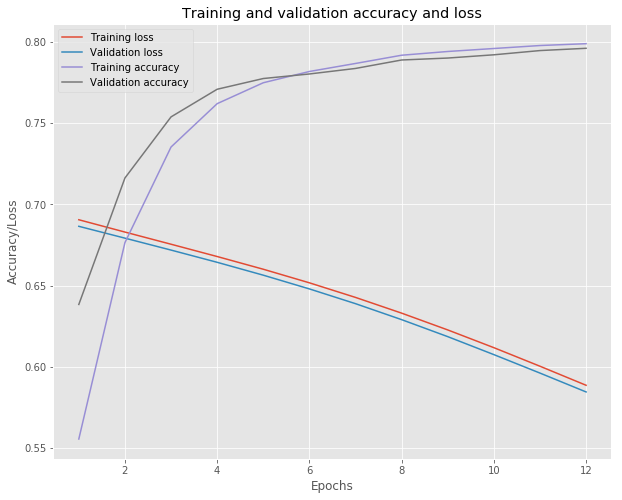

In [40]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')

plt.title('Training and validation accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

In [41]:
with tf.compat.v1.Session() as session:
  session.run(tf.compat.v1.global_variables_initializer())
  session.run(tf.compat.v1.tables_initializer())
  model.evaluate(np.array(test_reviews), np.array(test_sentiments))

   96/15000 [..............................] - ETA: 2:24 - loss: 0.6910 - accuracy: 0.5208

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff7f98a5cc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1456, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 548, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


15000/15000 [==============================] - 26s 2ms/sample - loss: 0.6923 - accuracy: 0.5186


In [42]:
from sklearn.metrics import classification_report

with tf.compat.v1.Session() as session:
  session.run(tf.compat.v1.global_variables_initializer())
  session.run(tf.compat.v1.tables_initializer())
  y_pred = model.predict(np.array(test_reviews))

print(classification_report(np.array(test_sentiments), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7490
           1       0.00      0.00      0.00      7510

   micro avg       0.50      0.50      0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.33     15000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
